In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
cd drive/MyDrive

/content/drive/MyDrive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from cvxopt import matrix, solvers

In [5]:
#ucitavanje dataseta
df=pd.read_csv('svmData.csv', header=None)

In [6]:
#razdvajanje prediktora i labels
X_df=df.iloc[:,:2]
Y_df=df.iloc[:,2:]

#standardizacija
srv=X_df.mean()
std=X_df.std(ddof=0)
X_df=(X_df - srv)/std
X_df=np.array(X_df)
Y_df=np.array(Y_df)
# standardizacija prediktora


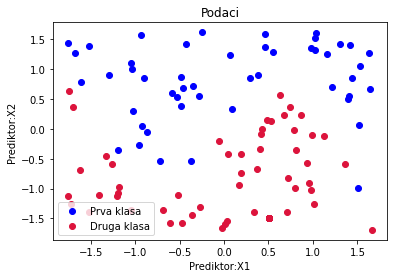

In [7]:
#prikaz linerno neseparabilnih podataka
plt.figure()
plt.title("Podaci")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_df[np.where(Y_df==1),0],X_df[np.where(Y_df==1),1], color="blue",label='Prva klasa')
plt.scatter(X_df[np.where(Y_df==-1),0],X_df[np.where(Y_df==-1),1],color="crimson", label='Druga klasa')
plt.legend(loc="best")
plt.show()

In [8]:
X_train,X_test,Y_train,Y_test=train_test_split(X_df,Y_df)
X_train.shape

(75, 2)

In [15]:
from numpy.core.fromnumeric import squeeze
c=[0.1,1,10,100]
loss_c = np.zeros(len(c))
valid_split = 5
error_valid = np.zeros(valid_split)
indecs=np.arange(len(X_train))
folds=np.array_split(indecs, indices_or_sections = valid_split)
for c_ind, c_i in enumerate(c):
  #podela seta na valid i train 
  for k, fold in enumerate(folds):
       X_valid, y_valid =np.mat(X_train[folds[k]]),np.mat(Y_train[folds[k]])
       train_indices = np.concatenate([folds[p] for p in range(len(folds)) if p != k])
       train_X, train_y = np.mat(X_train[train_indices]), np.mat(Y_train[train_indices])
       m,n=train_X.shape
       m_v,n_v=X_valid.shape
      
       
       
       #definisemo parametre za kvadratno programiranje
       H=np.zeros((m,m))
      
       for i in range(m):
         for j in range(m):
            H[i,j]= np.dot(train_X[i],np.transpose(train_X[j]))
            
       P = matrix(np.outer(train_y,train_y)*H)
       q = matrix(np.repeat([-1.0], m)[:, None])
       #q = matrix(-np.ones((m, 1)))
       G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
       h = matrix(np.hstack((np.zeros(m), np.ones(m) * c_i)))  
       #print(h.size)
       A = matrix(train_y.reshape(1, -1))
       A = A * 1.0 #mora A da bude tipa float
       b = matrix(np.zeros(1))
       solvers.options['show_progress'] = False
       solver = solvers.qp(P, q, G, h, A, b)
       alfa = np.ravel(solver['x'])
       sv= np.where((alfa>1e-5)&(alfa<=c_i))
       ind = np.arange(len(alfa))[sv]
       
       
       #odredjivanje w
       w=np.mat(np.zeros(n))# 
       for i in range(m):
         
         w += (alfa[i] * train_y[i] * train_X[i])
       w=np.transpose(w) 
       
      
       b = np.mean(train_y[ind]- np.dot(train_X[ind],w))
       
       for j in range (m_v):
            ypred = np.sign(w[0]*X_valid[j,0] + w[1]*X_valid[j,1]+b)
                
            if (ypred*y_valid[j]<0) :  # losa klasifikacija
                error_valid[k]=error_valid[k]+1;
                    
            error_valid[k] = error_valid[k]/m_v
   

            
  loss_c[c_ind]= np.sum(error_valid)/valid_split
  print(loss_c)    
    

[0.01422226 0.         0.         0.        ]
[0.01422226 0.02755559 0.         0.        ]
[0.01422226 0.02755559 0.02755559 0.        ]
[0.01422226 0.02755559 0.02755559 0.02755559]


In [16]:
c_optimalno=c[np.argmin(loss_c)]
print(c_optimalno)

0.1


In [17]:
m,n=X_train.shape

H=np.zeros((m,m))
      
for i in range(m):
    for j in range(m):
            H[i,j]= np.dot(X_train[i],np.transpose(X_train[j]))
            
P = matrix(np.outer(Y_train,Y_train)*H)
q = matrix(np.repeat([-1.0], m)[:, None])
#q = matrix(-np.ones((m, 1)))
G = matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = matrix(np.hstack((np.zeros(m), np.ones(m) * c_optimalno)))  
#print(h.size)
A = matrix(Y_train.reshape(1, -1))
A = A * 1.0 #mora A da bude tipa float
b = matrix(np.zeros(1))
solvers.options['show_progress'] = False
solver = solvers.qp(P, q, G, h, A, b)
alfa = np.ravel(solver['x'])
sv= np.where((alfa>1e-5)&(alfa<=c_i))
ind = np.arange(len(alfa))[sv]
       
       
#odredjivanje w
w=np.mat(np.zeros(n))
for i in range(m):
       
    w += (alfa[i] * Y_train[i] * X_train[i])
w=np.transpose(w)
print()
b = np.mean(Y_train[ind]- np.dot(X_train[ind],w))



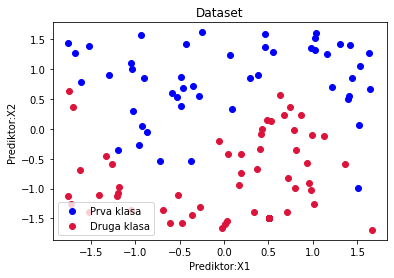

In [19]:
#dataset
plt.figure()
plt.title("Dataset")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_df[np.where(Y_df==1),0],X_df[np.where(Y_df==1),1], color="blue",label='Prva klasa')
plt.scatter(X_df[np.where(Y_df==-1),0],X_df[np.where(Y_df==-1),1],color="crimson", label='Druga klasa')
plt.legend(loc="best")
plt.show()


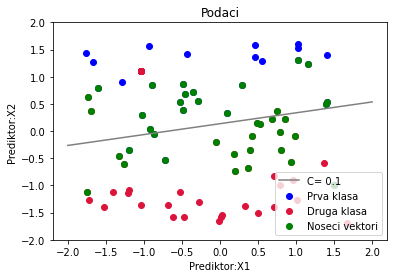

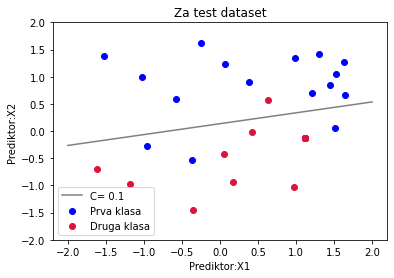

In [20]:
#trenig set
plt.figure()
plt.title("Podaci")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_train[np.where(Y_train==1),0],X_train[np.where(Y_train==1),1], color="blue",label='Prva klasa')
plt.scatter(X_train[np.where(Y_train==-1),0],X_train[np.where(Y_train==-1),1],color="crimson", label='Druga klasa')
# noseći vektori
plt.scatter(X_train[ind,0],X_train[ind,1], color="green",label='Noseci vektori')
#separaciona kriva 
w= np.asarray(w).reshape(-1)    
plt.plot([-2,2], [-b/w[1]+2*w[0]/w[1],-b/w[1]-2*w[0]/w[1]],color="grey",label='C= '+str(c_optimalno))

plt.ylim(ymax = 2, ymin = -2)
plt.legend(loc="best")
plt.show()

#test set
plt.figure()
plt.title("Za test dataset")
plt.xlabel("Prediktor:X1")
plt.ylabel("Prediktor:X2")
plt.scatter(X_test[np.where(Y_test==1),0],X_test[np.where(Y_test==1),1], color="blue",label='Prva klasa')
plt.scatter(X_test[np.where(Y_test==-1),0],X_test[np.where(Y_test==-1),1],color="crimson", label='Druga klasa')
# noseći vektori
#plt.scatter(X_test[ind,0],X_test[ind,1], color="green",label='Noseci vektori')
#separaciona kriva 
w= np.asarray(w).reshape(-1)    
plt.plot([-2,2], [-b/w[1]+2*w[0]/w[1],-b/w[1]-2*w[0]/w[1]],color="grey",label='C= '+str(c_optimalno))

plt.ylim(ymax = 2, ymin = -2)
plt.legend(loc="best")
plt.show()
